Implement RNN from scratch to predict Google's 'Open', 'High', 'Low' & 'Volume' figures from 2021 onwards.

Import the necessary libraries

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error
import torch
from torch import nn

Split the data into train and test set and plot the data

============================== Train Data ==============================

         Date       Open       High        Low      Close  Adj Close    Volume
0  2004-08-19  50.050049  52.082081  48.028027  50.220219  50.220219  44659096
1  2004-08-20  50.555557  54.594597  50.300301  54.209209  54.209209  22834343
2  2004-08-23  55.430431  56.796799  54.579578  54.754753  54.754753  18256126
3  2004-08-24  55.675674  55.855858  51.836838  52.487488  52.487488  15247337
4  2004-08-25  52.532532  54.054054  51.991993  53.053055  53.053055   9188602

============================== Test Data ==============================

            Date         Open         High          Low        Close  \
4097  2020-11-25  1767.810059  1770.380005  1748.359985  1764.130005   
4098  2020-11-27  1764.540039  1797.010010  1764.540039  1787.020020   
4099  2020-11-30  1775.650024  1780.339966  1747.839966  1754.400024   
4100  2020-12-01  1766.660034  1821.719971  1763.030029  1795.359985   
4101  2020-12-02  

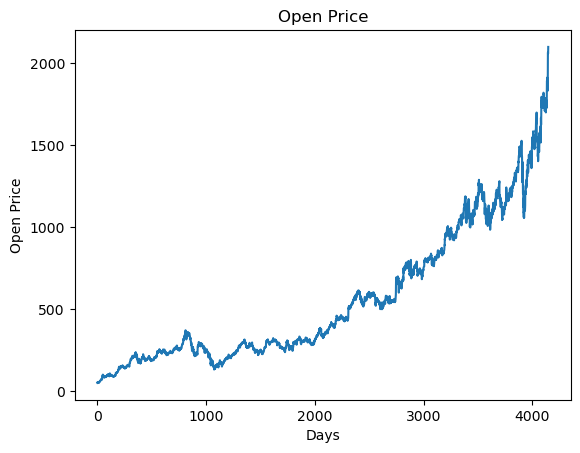

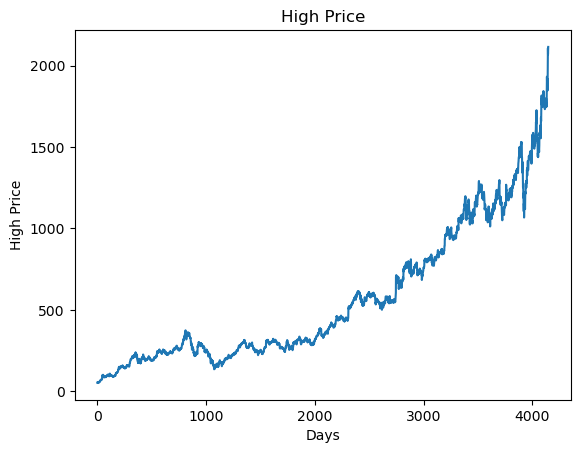

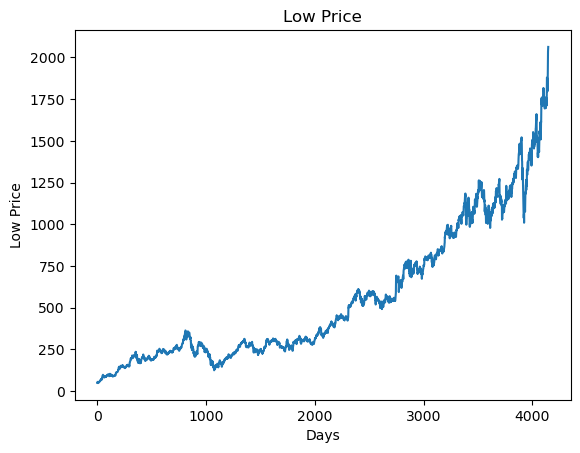

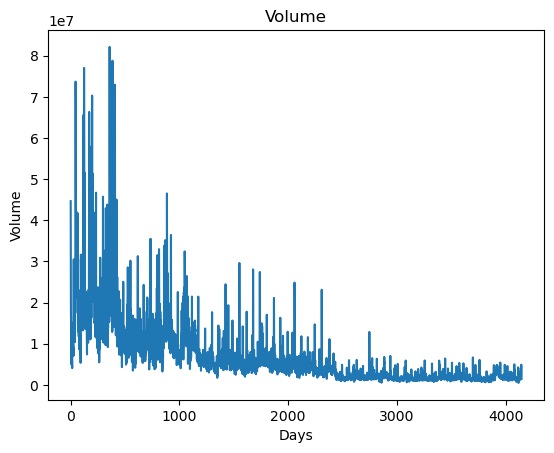

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [49]:
data = pd.read_csv('/Users/sid/Desktop/Sem 6/ELL884/ELL884-a2/GOOGL.csv')  

time_step = 25

train_data = data[:4122 + time_step]
test_data = data[4122 - time_step:]

print('='*30 + ' Train Data ' + '='*30)
print()
print(train_data.head())
print()
print('='*30 + ' Test Data ' + '='*30)
print()
print(test_data.head())
print()

print('Length of train data ', len(train_data))
print('Length of test data: ', len(test_data))

print(train_data.shape)
print(test_data.shape)



# Plot the variable which we need to predict
plt.plot(train_data['Open'])
plt.xlabel('Days')
plt.ylabel('Open Price')
plt.title('Open Price')
plt.show()

plt.plot(train_data['High'])
plt.xlabel('Days')
plt.ylabel('High Price')
plt.title('High Price')
plt.show()

plt.plot(train_data['Low'])
plt.xlabel('Days')
plt.ylabel('Low Price')
plt.title('Low Price')
plt.show()

plt.plot(train_data['Volume'])
plt.xlabel('Days')
plt.ylabel('Volume')
plt.title('Volume')
plt.show()

# check for missing values
print(test_data.isna().any())

Scale the data for ease of processing, drop the values we dont want to predict and plot the scaled data

             Open         High          Low   Volume
4097  1767.810059  1770.380005  1748.359985   980000
4098  1764.540039  1797.010010  1764.540039   739500
4099  1775.650024  1780.339966  1747.839966  1620900
4100  1766.660034  1821.719971  1763.030029  1867500
4101  1795.359985  1832.739990  1785.170044  1471200
       Open      High       Low    Volume
0  0.841814  0.837059  0.847340  0.011929
1  0.840257  0.849650  0.855182  0.009002
2  0.845548  0.841768  0.847088  0.019731
3  0.841267  0.861333  0.854450  0.022732
4  0.854933  0.866544  0.865180  0.017908
         Date      Open      High       Low    Volume
0  2020-11-25  0.841814  0.837059  0.847340  0.011929
1  2020-11-27  0.840257  0.849650  0.855182  0.009002
2  2020-11-30  0.845548  0.841768  0.847088  0.019731
3  2020-12-01  0.841267  0.861333  0.854450  0.022732
4  2020-12-02  0.854933  0.866544  0.865180  0.017908


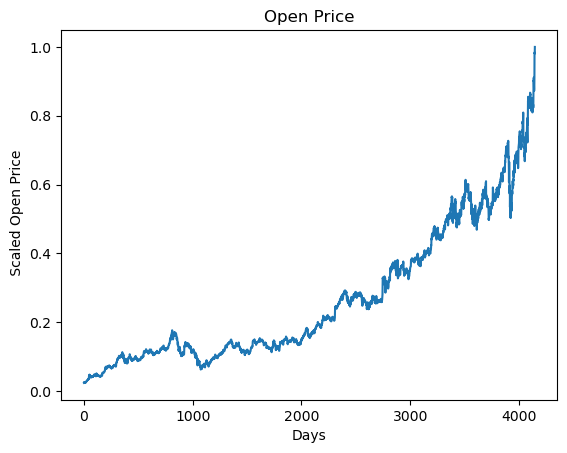

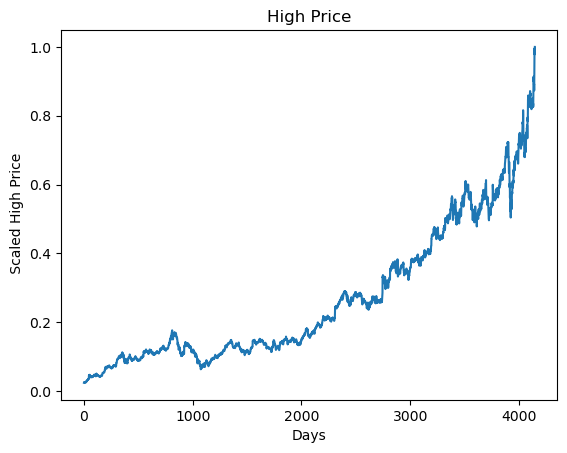

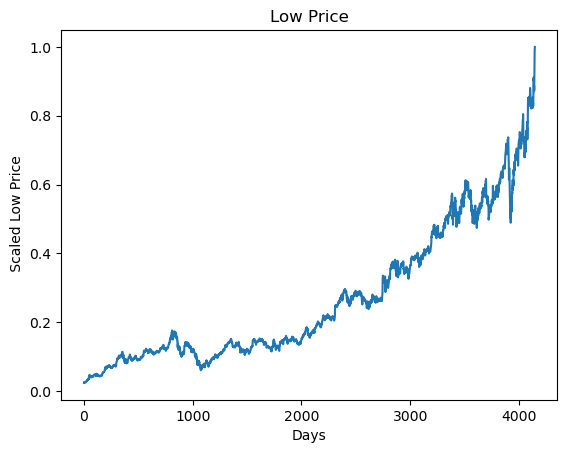

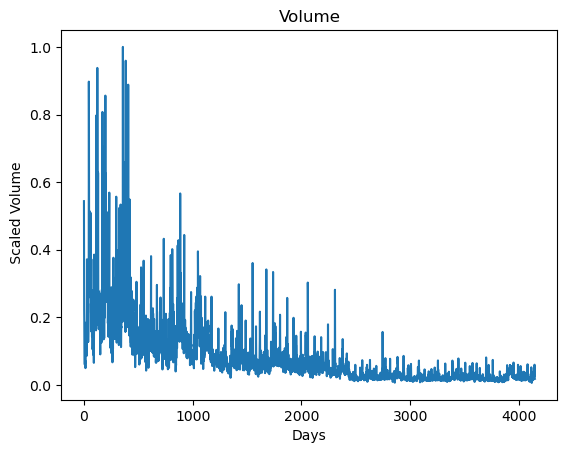

In [50]:
stdscaler = StandardScaler()
minmaxscaler = MinMaxScaler()
maxabsscaler = MaxAbsScaler()

train_dates = train_data['Date']
test_dates = test_data['Date']
train_data = train_data.drop(['Date'], axis=1)
test_data = test_data.drop(['Date'], axis=1)

train_data = train_data.drop(['Close'], axis=1)
train_data = train_data.drop(['Adj Close'], axis=1)
test_data = test_data.drop(['Close'], axis=1)
test_data = test_data.drop(['Adj Close'], axis=1)


print(test_data.head())

# Store column names
column_names = train_data.columns

# Scale the data to 0 mean and unit variance
train_data = maxabsscaler.fit_transform(train_data)
test_data = maxabsscaler.transform(test_data)


# Convert back to DataFrame and reassign column names
train_data = pd.DataFrame(train_data, columns=column_names)
test_data = pd.DataFrame(test_data, columns=column_names)

train_dates = train_dates.reset_index(drop=True)
test_dates = test_dates.reset_index(drop=True)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print(test_data.head())

# Add the dates back in
train_data = pd.concat([train_dates, pd.DataFrame(train_data)], axis=1)
test_data = pd.concat([test_dates, pd.DataFrame(test_data)], axis=1)

print(test_data.head())


# Plot the variable which we need to predict
plt.plot(train_data['Open'])
plt.xlabel('Days')
plt.ylabel(' Scaled Open Price')
plt.title('Open Price')
plt.show()

plt.plot(train_data['High'])
plt.xlabel('Days')
plt.ylabel(' Scaled High Price')
plt.title('High Price')
plt.show()

plt.plot(train_data['Low'])
plt.xlabel('Days')
plt.ylabel(' Scaled Low Price')
plt.title('Low Price')
plt.show()

plt.plot(train_data['Volume'])
plt.xlabel('Days')
plt.ylabel(' Scaled Volume')
plt.title('Volume')
plt.show()



Process the data to contain the stock prices of previous time_step days

In [51]:
X_train  = []
y_train = []


for i in range(time_step, len(train_data)):
    X_train.append(train_data.iloc[i-time_step:i ,[1,2,3,4]].values.astype(float))
    y_train.append(train_data.iloc[i,[1,2,3,4]].values.astype(float))
    
X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

delta = 4000
print(X_train[50+delta][0] == y_train[delta])
print(y_train[delta])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

Shape of X_train before reshape : (4122, 25, 4)
Shape of y_train before reshape : (4122, 4)
[False False False False]
[0.72076666 0.71857685 0.72648844 0.01335465]


Process the data to contain the stock prices of previous time_step days

In [52]:
X_test = []
y_test = []

for i in range(time_step, len(test_data)):
    X_test.append(test_data.iloc[i-time_step:i ,[1,2,3,4]].values.astype(float))
    y_test.append(test_data.iloc[i,[1,2,3,4]].values.astype(float))
    
X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

Shape of X_test before reshape : (309, 25, 4)
Shape of y_test before reshape : (309, 4)


Define the RNN with appropriate hyperparameters and run the training loop

In [53]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)  # initial hidden state
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  # output of the last time step
        return out

# Hyperparameters
input_dim = 4 # number of features in the input
hidden_dim = 50  # number of features in the hidden state
num_layers = 1  # number of stacked RNN layers
output_dim = 4  # number of features in the output
dropout = 0.2  # dropout rate


# Create the model
model = RNN(input_dim, hidden_dim, num_layers, output_dim, dropout)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

loss_values = []

# Training loop
for epoch in range(1000):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    print(f'Epoch {epoch+1}/{1000}, Loss: {loss.item()}')

Epoch 1/1000, Loss: 0.11515376716852188
Epoch 2/1000, Loss: 0.10163313895463943


/Users/sid/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/var/folders/kg/83yggpd52hj0w051vwc_fnqc0000gn/T/ipykernel_6251/1364953977.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Epoch 3/1000, Loss: 0.09030486643314362
Epoch 4/1000, Loss: 0.07995093613862991
Epoch 5/1000, Loss: 0.07085227966308594
Epoch 6/1000, Loss: 0.0626152753829956
Epoch 7/1000, Loss: 0.05593986436724663
Epoch 8/1000, Loss: 0.04897809028625488
Epoch 9/1000, Loss: 0.04371322691440582
Epoch 10/1000, Loss: 0.038600854575634
Epoch 11/1000, Loss: 0.03442557528614998
Epoch 12/1000, Loss: 0.03109249286353588
Epoch 13/1000, Loss: 0.028562678024172783
Epoch 14/1000, Loss: 0.02681465446949005
Epoch 15/1000, Loss: 0.025262348353862762
Epoch 16/1000, Loss: 0.02404605597257614
Epoch 17/1000, Loss: 0.02347237430512905
Epoch 18/1000, Loss: 0.021740665659308434
Epoch 19/1000, Loss: 0.02116236463189125
Epoch 20/1000, Loss: 0.019945116713643074
Epoch 21/1000, Loss: 0.018774524331092834
Epoch 22/1000, Loss: 0.017804304137825966
Epoch 23/1000, Loss: 0.01671302132308483
Epoch 24/1000, Loss: 0.015132117085158825
Epoch 25/1000, Loss: 0.01364537887275219
Epoch 26/1000, Loss: 0.01244528591632843
Epoch 27/1000, Loss

Plot the loss w.r.t epochs

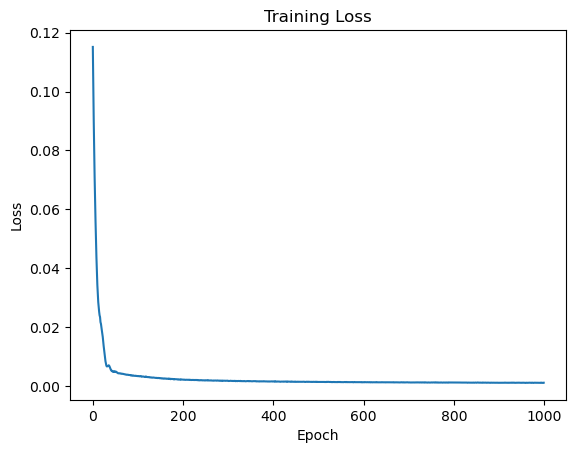

In [54]:
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Evaluate the model and calculate the MSE on the train and test sets

In [55]:
model.eval()

# Predict the target variables
with torch.no_grad():
    y_pred_train = model(X_train)
    y_pred_test = model(X_test)

# Inverse scaling
y_train = maxabsscaler.inverse_transform(y_train)
y_test = maxabsscaler.inverse_transform(y_test)
y_pred_train = maxabsscaler.inverse_transform(y_pred_train)
y_pred_test = maxabsscaler.inverse_transform(y_pred_test)

print(y_pred_test.shape)

# Calculate MSE for training data
mse_train_open = mean_squared_error(y_train[:, 0], y_pred_train[:, 0])
mse_train_high = mean_squared_error(y_train[:, 1], y_pred_train[:, 1])
mse_train_low = mean_squared_error(y_train[:, 2], y_pred_train[:, 2])
mse_train_volume = mean_squared_error(y_train[:, 3], y_pred_train[:, 3])

# Calculate MSE for test data
mse_test_open = mean_squared_error(y_test[:, 0], y_pred_test[:, 0])
mse_test_high = mean_squared_error(y_test[:, 1], y_pred_test[:, 1])
mse_test_low = mean_squared_error(y_test[:, 2], y_pred_test[:, 2])
mse_test_volume = mean_squared_error(y_test[:, 3], y_pred_test[:, 3])

print('='*30 + ' Root Mean Squared Error on Open ' + '='*30)
print()
print(f'Training RMSE on Open: {np.sqrt(mse_train_open)}')
print(f'Test RMSE on Open: {np.sqrt(mse_test_open)}')
print()

print('='*30 + ' Mean Squared Error on High ' + '='*30)
print()
print(f'Training RMSE on High: {np.sqrt(mse_train_high)}')
print(f'Test RMSE on High: {np.sqrt(mse_test_high)}')
print()

print('='*30 + ' Mean Squared Error on Low ' + '='*30)
print()
print(f'Training RMSE on Low: {np.sqrt(mse_train_low)}')
print(f'Test RMSE on Low: {np.sqrt(mse_test_low)}')
print()

print('='*30 + ' Mean Squared Error on Volume ' + '='*30)
print()
print(f'Training RMSE on Volume: {np.sqrt(mse_train_volume)}')
print(f'Test RMSE on Volume: {np.sqrt(mse_test_volume)}')
print()


# Add the last point of the training set to the beginning of the test set
y_test = np.concatenate(([y_train[-1]], y_test))
y_pred_test = np.concatenate(([y_pred_train[-1]], y_pred_test))


(309, 4)
============================== Root Mean Squared Error on Open ==============================

Training RMSE on Open: 15.527372084785227
Test RMSE on Open: 164.74717029022707

============================== Mean Squared Error on High ==============================

Training RMSE on High: 15.812190280464288
Test RMSE on High: 128.54799482248995

============================== Mean Squared Error on Low ==============================

Training RMSE on Low: 15.505523635505991
Test RMSE on Low: 135.18376827309302

============================== Mean Squared Error on Volume ==============================

Training RMSE on Volume: 3994991.8809951744
Test RMSE on Volume: 1414149.1932874895



/var/folders/kg/83yggpd52hj0w051vwc_fnqc0000gn/T/ipykernel_6251/1364953977.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Plot the predicted prices against the true prices

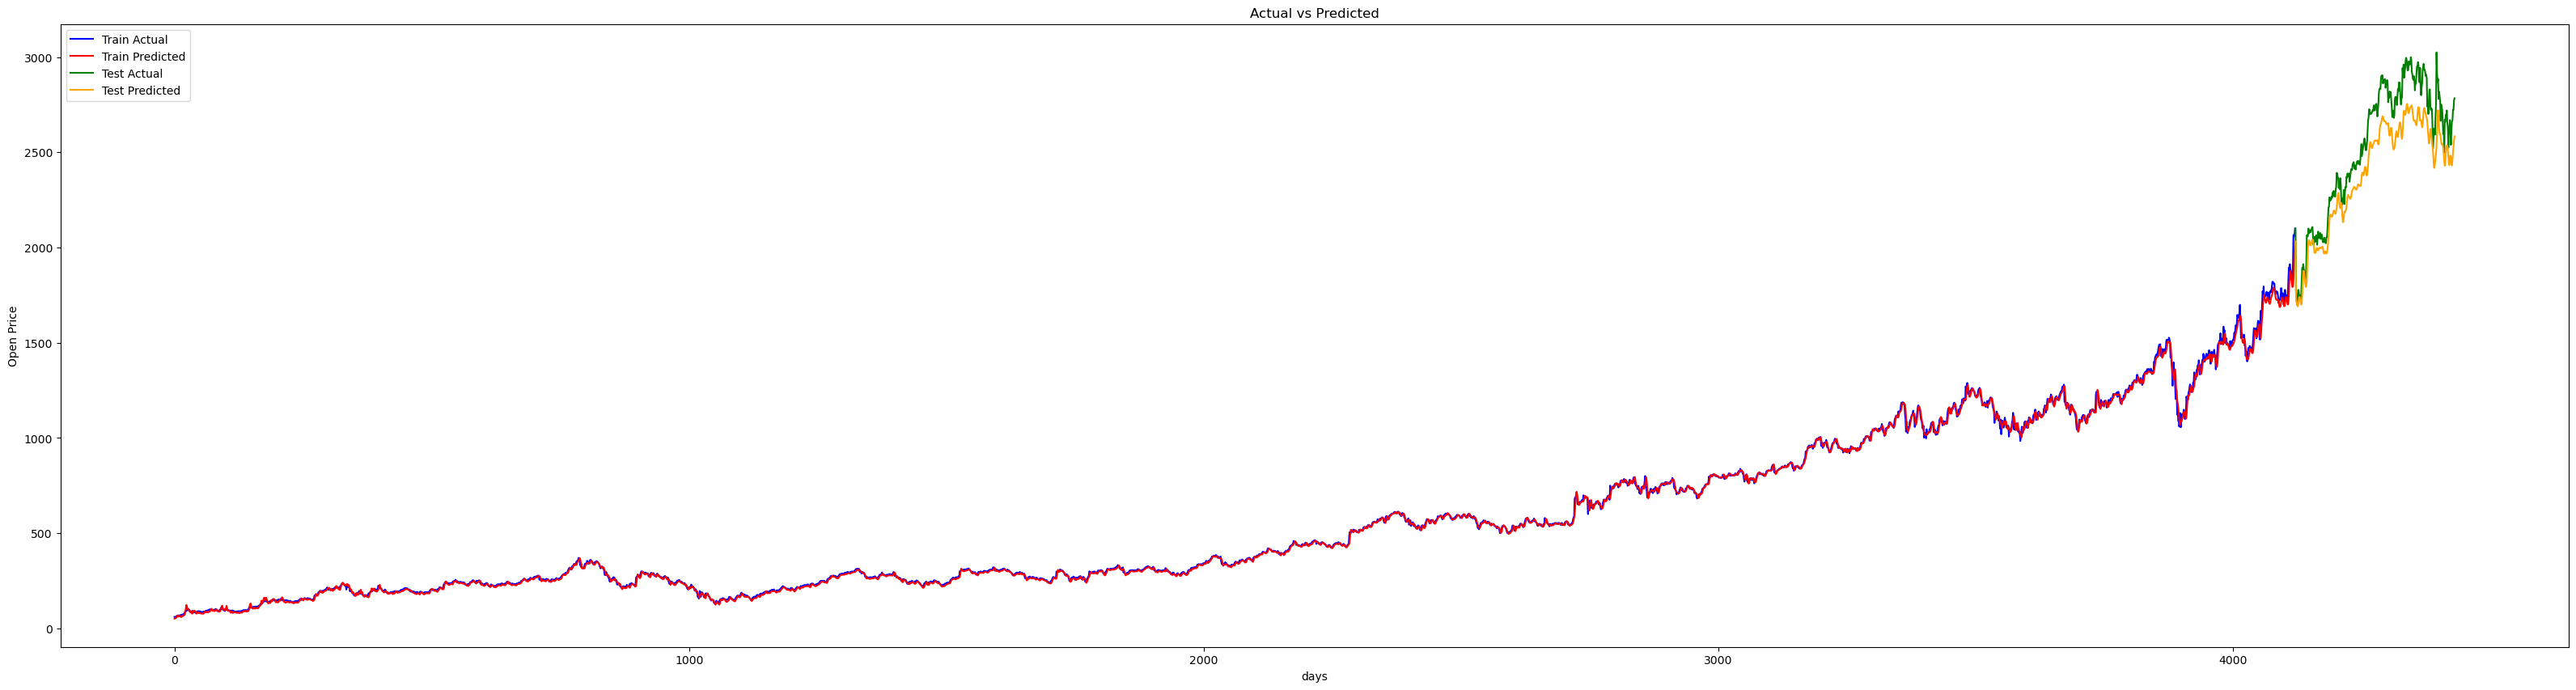

In [56]:
# Plotting for both the training and test set
plt.figure(figsize=(40,10))
plt.plot(np.arange(len(y_train)), y_train[:, 0], color='blue', label='Train Actual')
plt.plot(np.arange(len(y_train)), y_pred_train[:, 0], color='red', label='Train Predicted')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test[:, 0], color='green', label='Test Actual')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_test)), y_pred_test[:, 0], color='orange', label='Test Predicted')

plt.title('Actual vs Predicted')
plt.xlabel('days')
plt.ylabel('Open Price')
plt.legend()
plt.show()

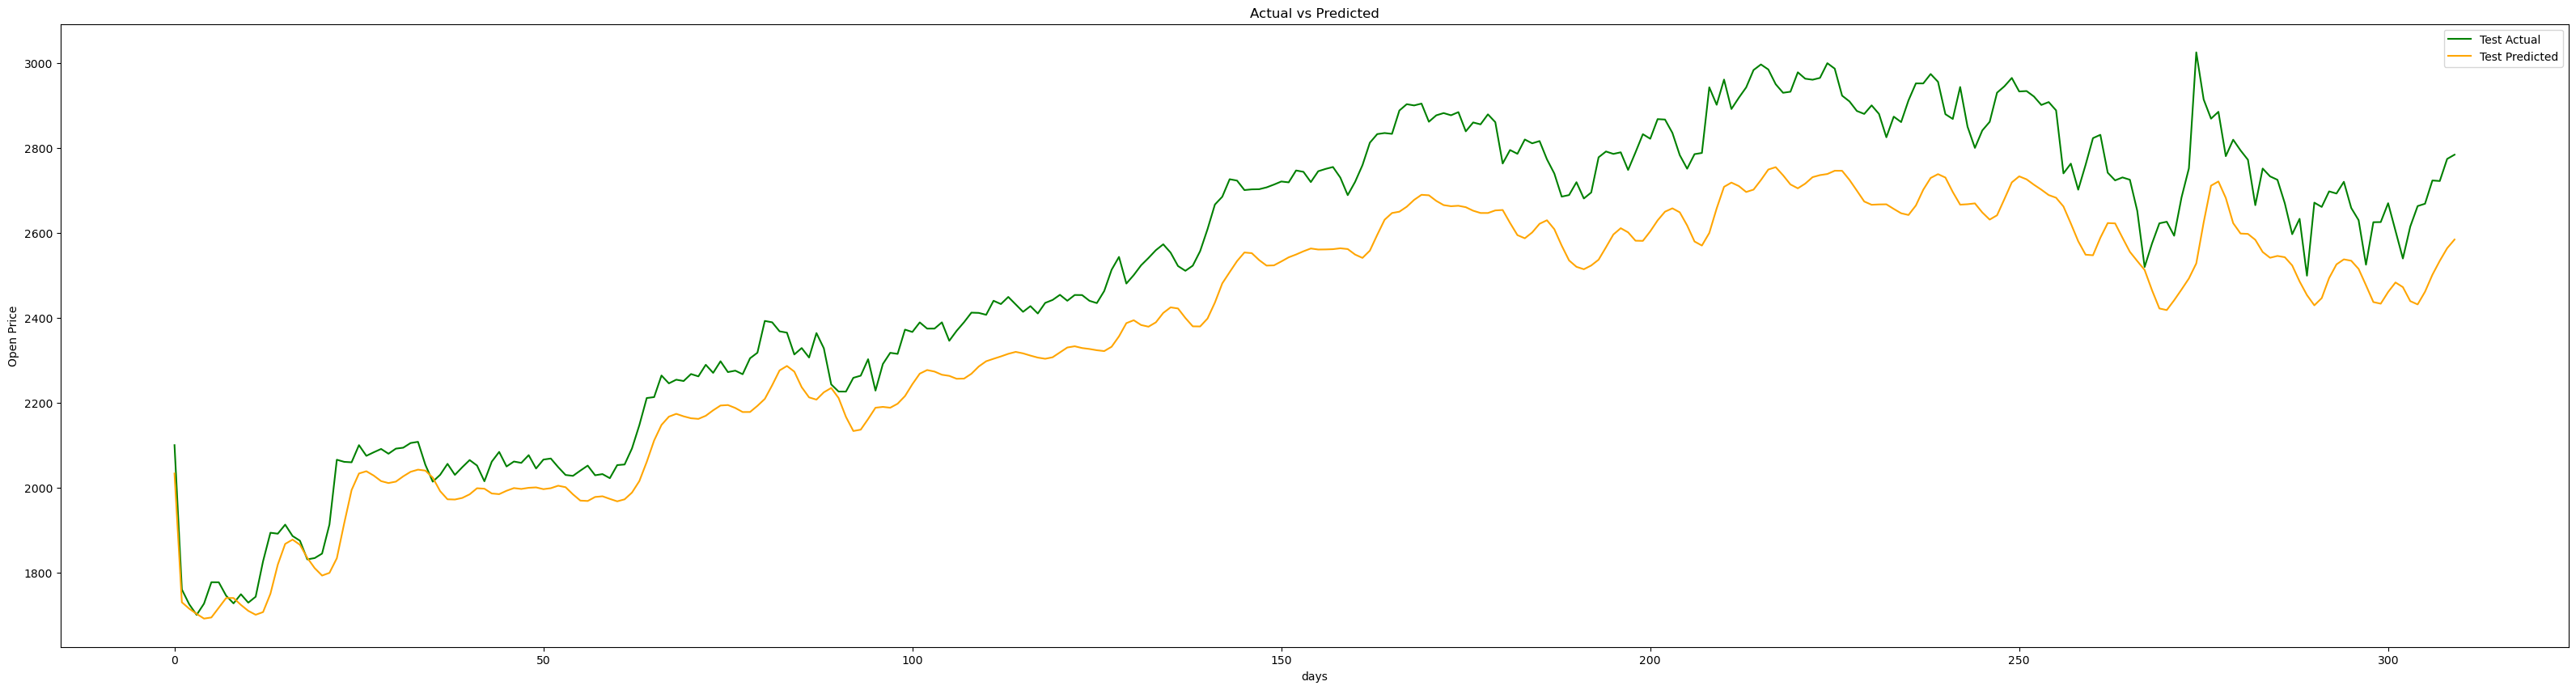

In [57]:
plt.figure(figsize=(40,10))
plt.plot(np.arange(len(y_test)), y_test[:, 0], color='green', label='Test Actual')
plt.plot(np.arange(len(y_pred_test)), y_pred_test[:, 0], color='orange', label='Test Predicted')

plt.title('Actual vs Predicted')
plt.xlabel('days')
plt.ylabel('Open Price')
plt.legend()
plt.show()

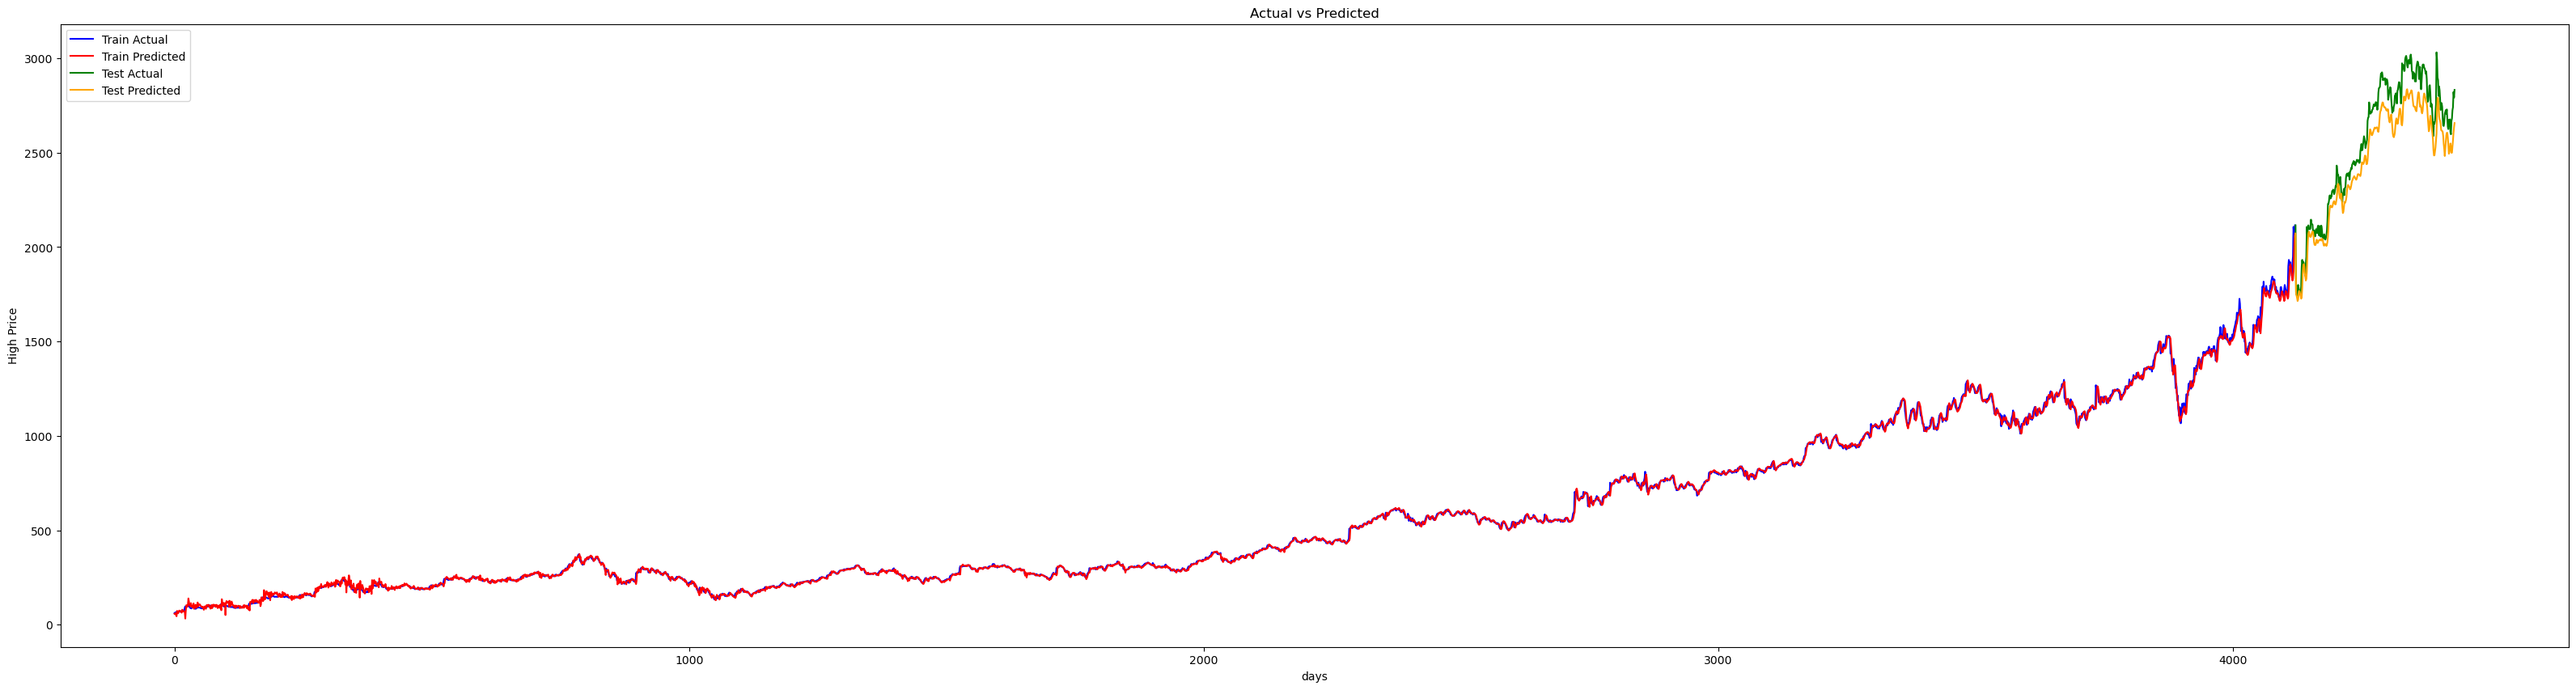

In [58]:
# Plotting for both the training and test set
plt.figure(figsize=(40,10))
plt.plot(np.arange(len(y_train)), y_train[:, 1], color='blue', label='Train Actual')
plt.plot(np.arange(len(y_train)), y_pred_train[:, 1], color='red', label='Train Predicted')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test[:, 1], color='green', label='Test Actual')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_test)), y_pred_test[:, 1], color='orange', label='Test Predicted')

plt.title('Actual vs Predicted')
plt.xlabel('days')
plt.ylabel('High Price')
plt.legend()
plt.show()

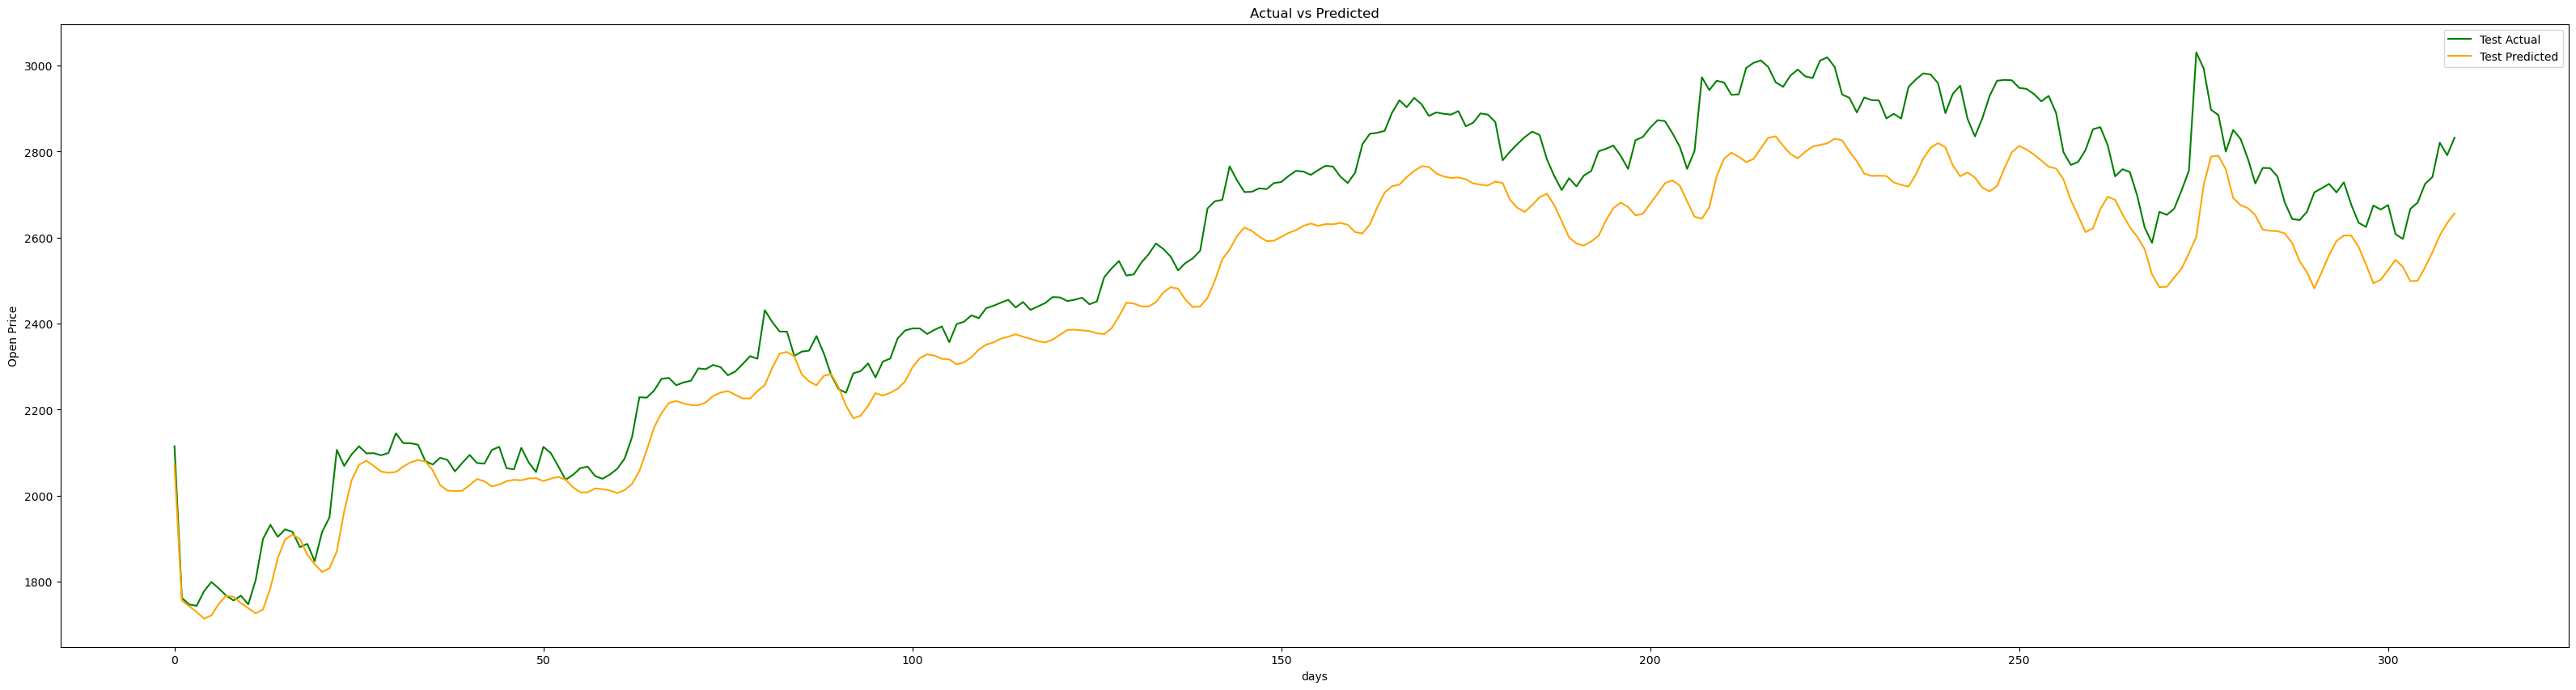

In [59]:
plt.figure(figsize=(40,10))
plt.plot(np.arange(len(y_test)), y_test[:, 1], color='green', label='Test Actual')
plt.plot(np.arange(len(y_pred_test)), y_pred_test[:, 1], color='orange', label='Test Predicted')

plt.title('Actual vs Predicted')
plt.xlabel('days')
plt.ylabel('Open Price')
plt.legend()
plt.show()

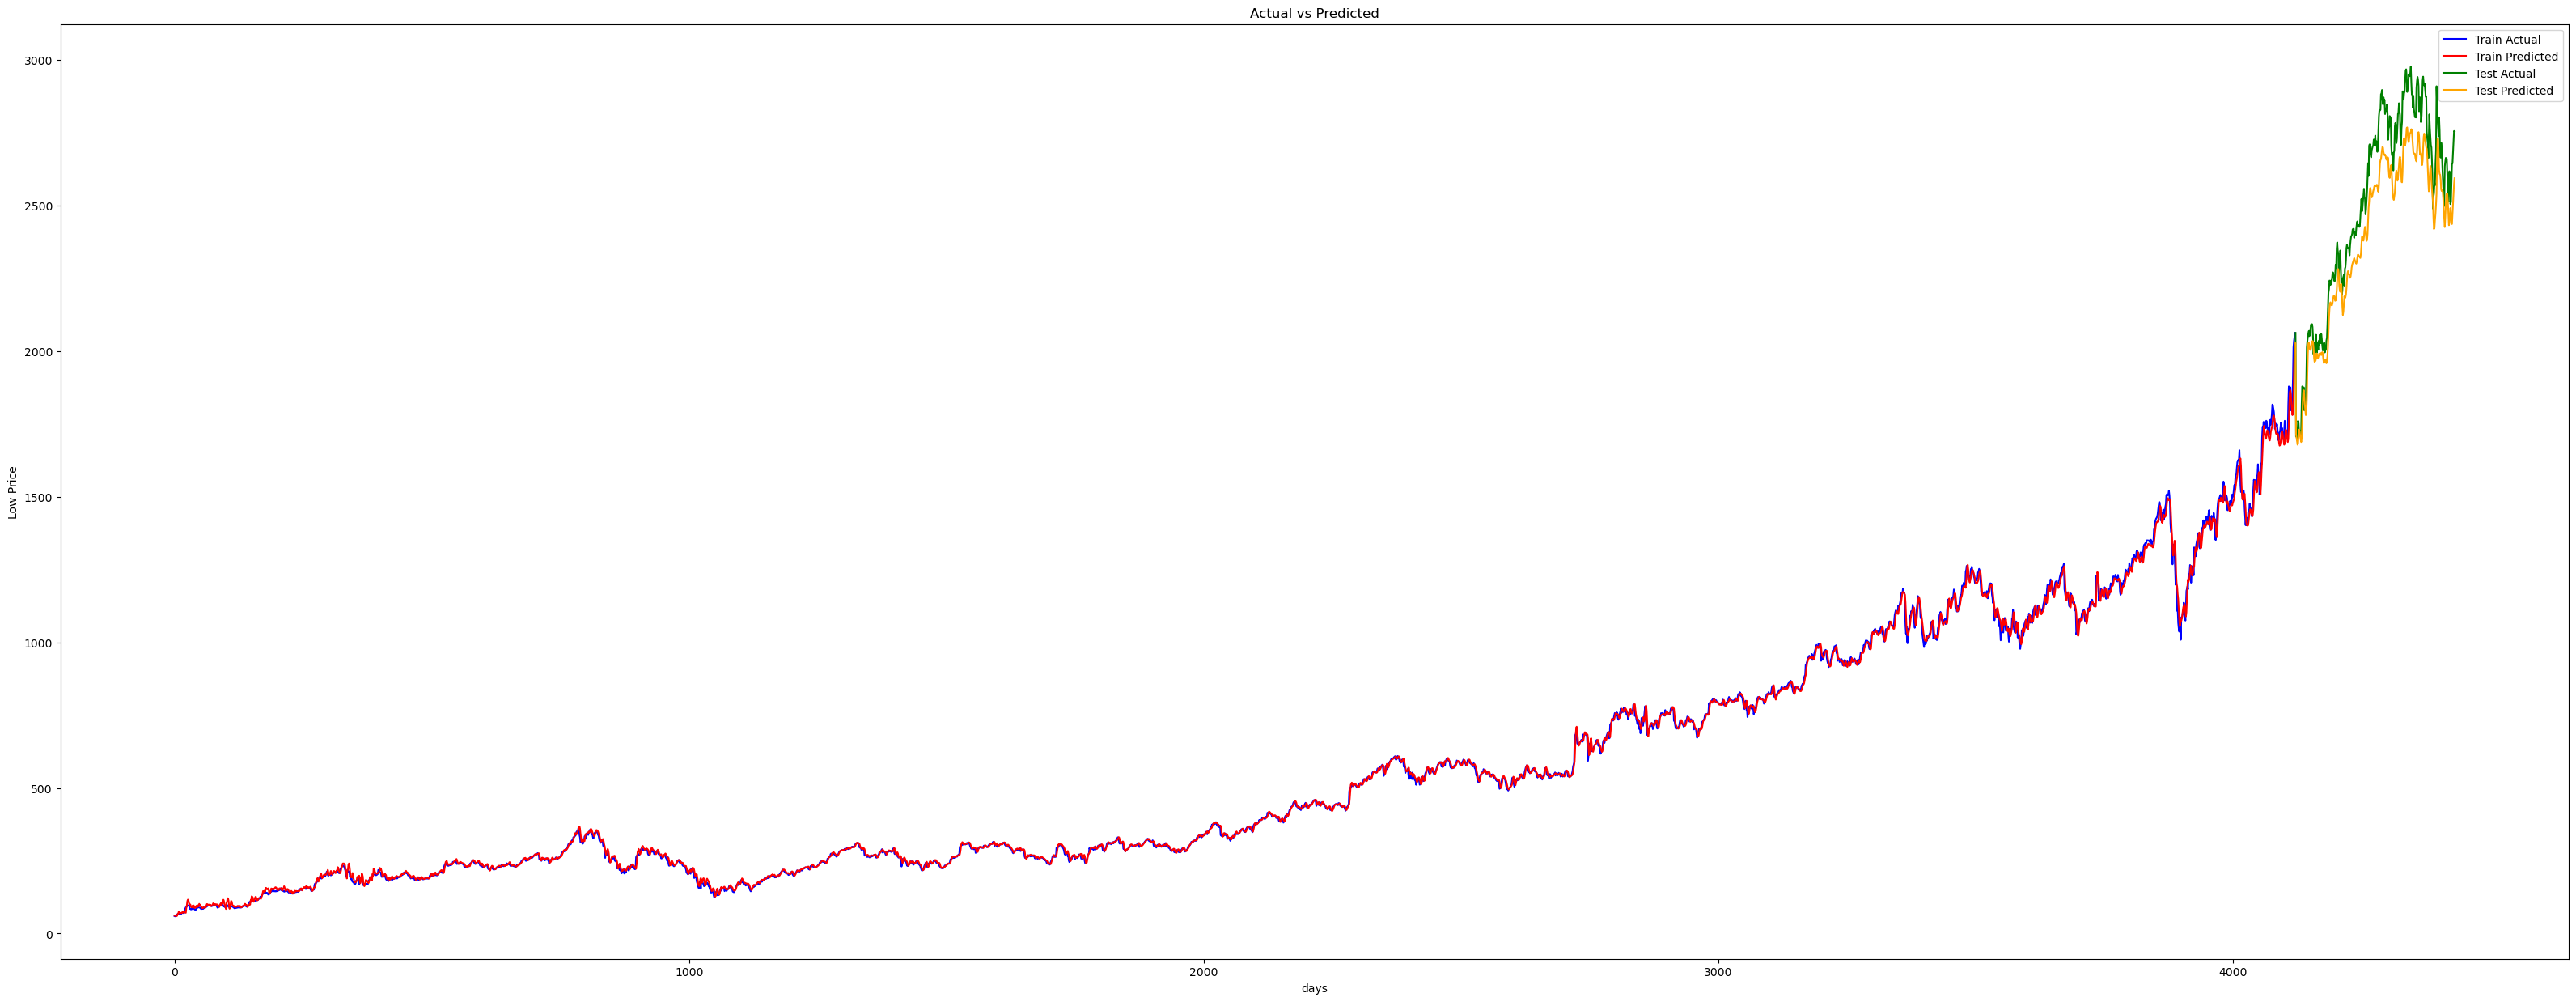

In [60]:
# Plotting for both the training and test set
plt.figure(figsize=(40,15))
plt.plot(np.arange(len(y_train)), y_train[:, 2], color='blue', label='Train Actual')
plt.plot(np.arange(len(y_train)), y_pred_train[:, 2], color='red', label='Train Predicted')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test[:, 2], color='green', label='Test Actual')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_test)), y_pred_test[:, 2], color='orange', label='Test Predicted')

plt.title('Actual vs Predicted')
plt.xlabel('days')
plt.ylabel('Low Price')
plt.legend()
plt.show()

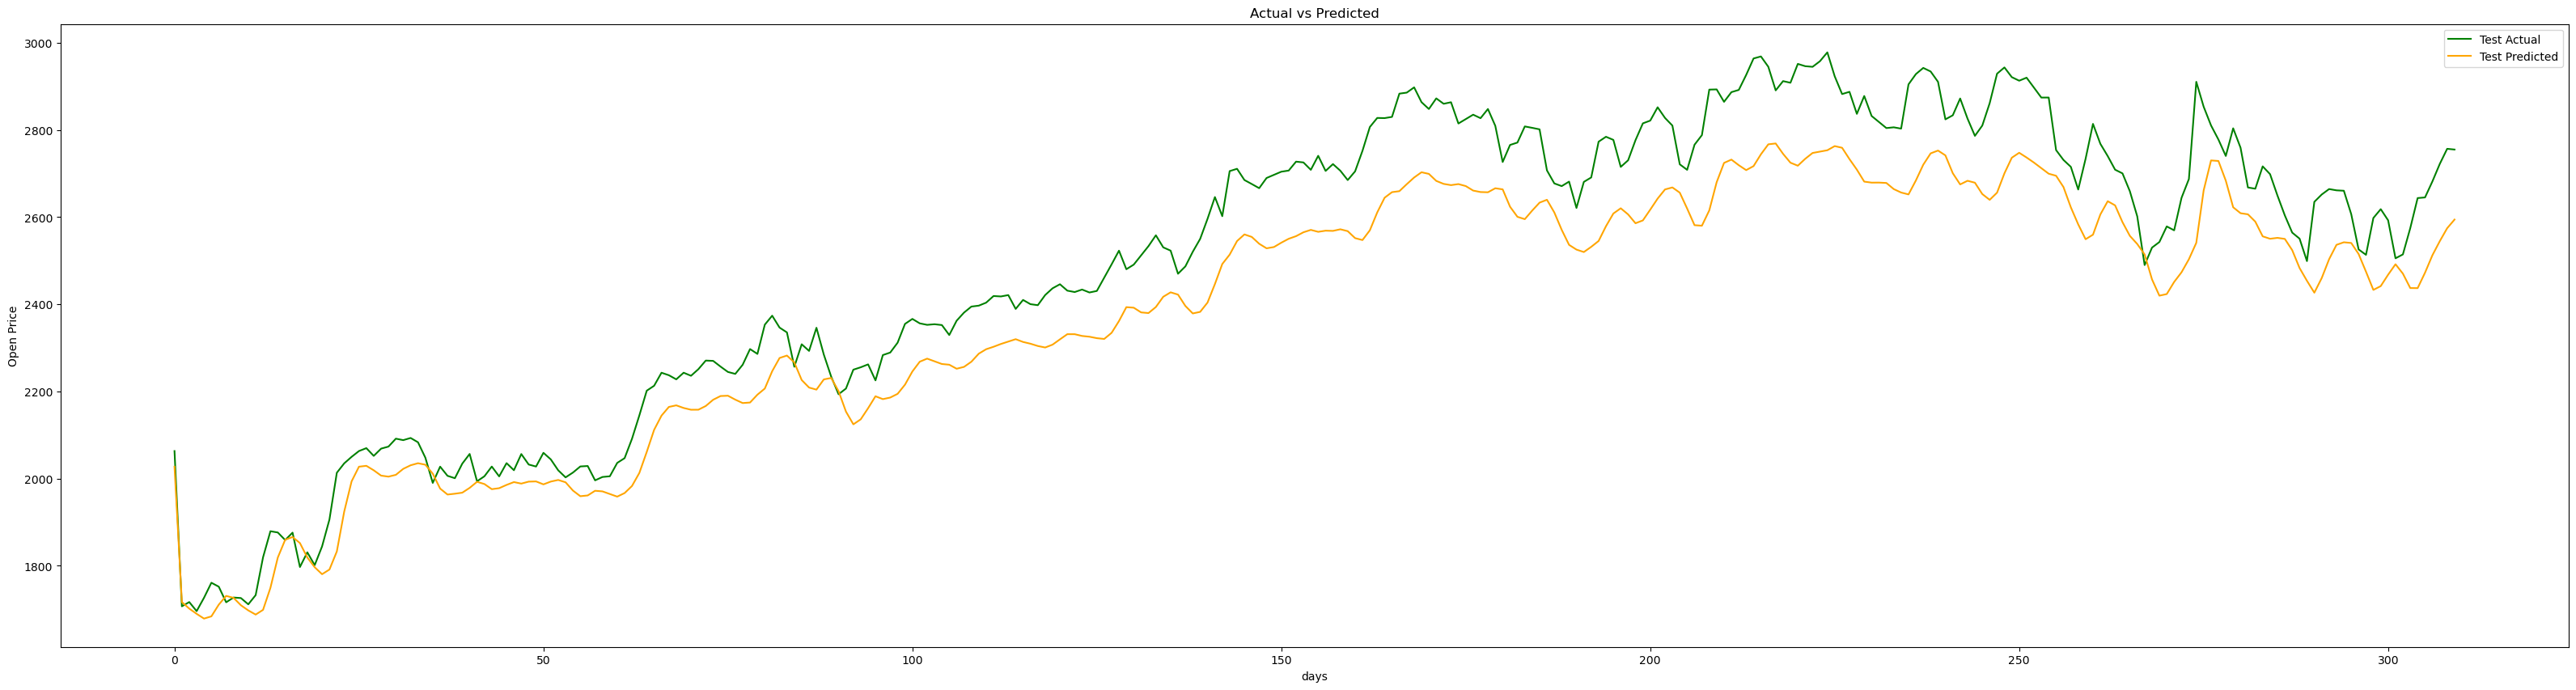

In [61]:
plt.figure(figsize=(40,10))
plt.plot(np.arange(len(y_test)), y_test[:, 2], color='green', label='Test Actual')
plt.plot(np.arange(len(y_pred_test)), y_pred_test[:, 2], color='orange', label='Test Predicted')

plt.title('Actual vs Predicted')
plt.xlabel('days')
plt.ylabel('Open Price')
plt.legend()
plt.show()

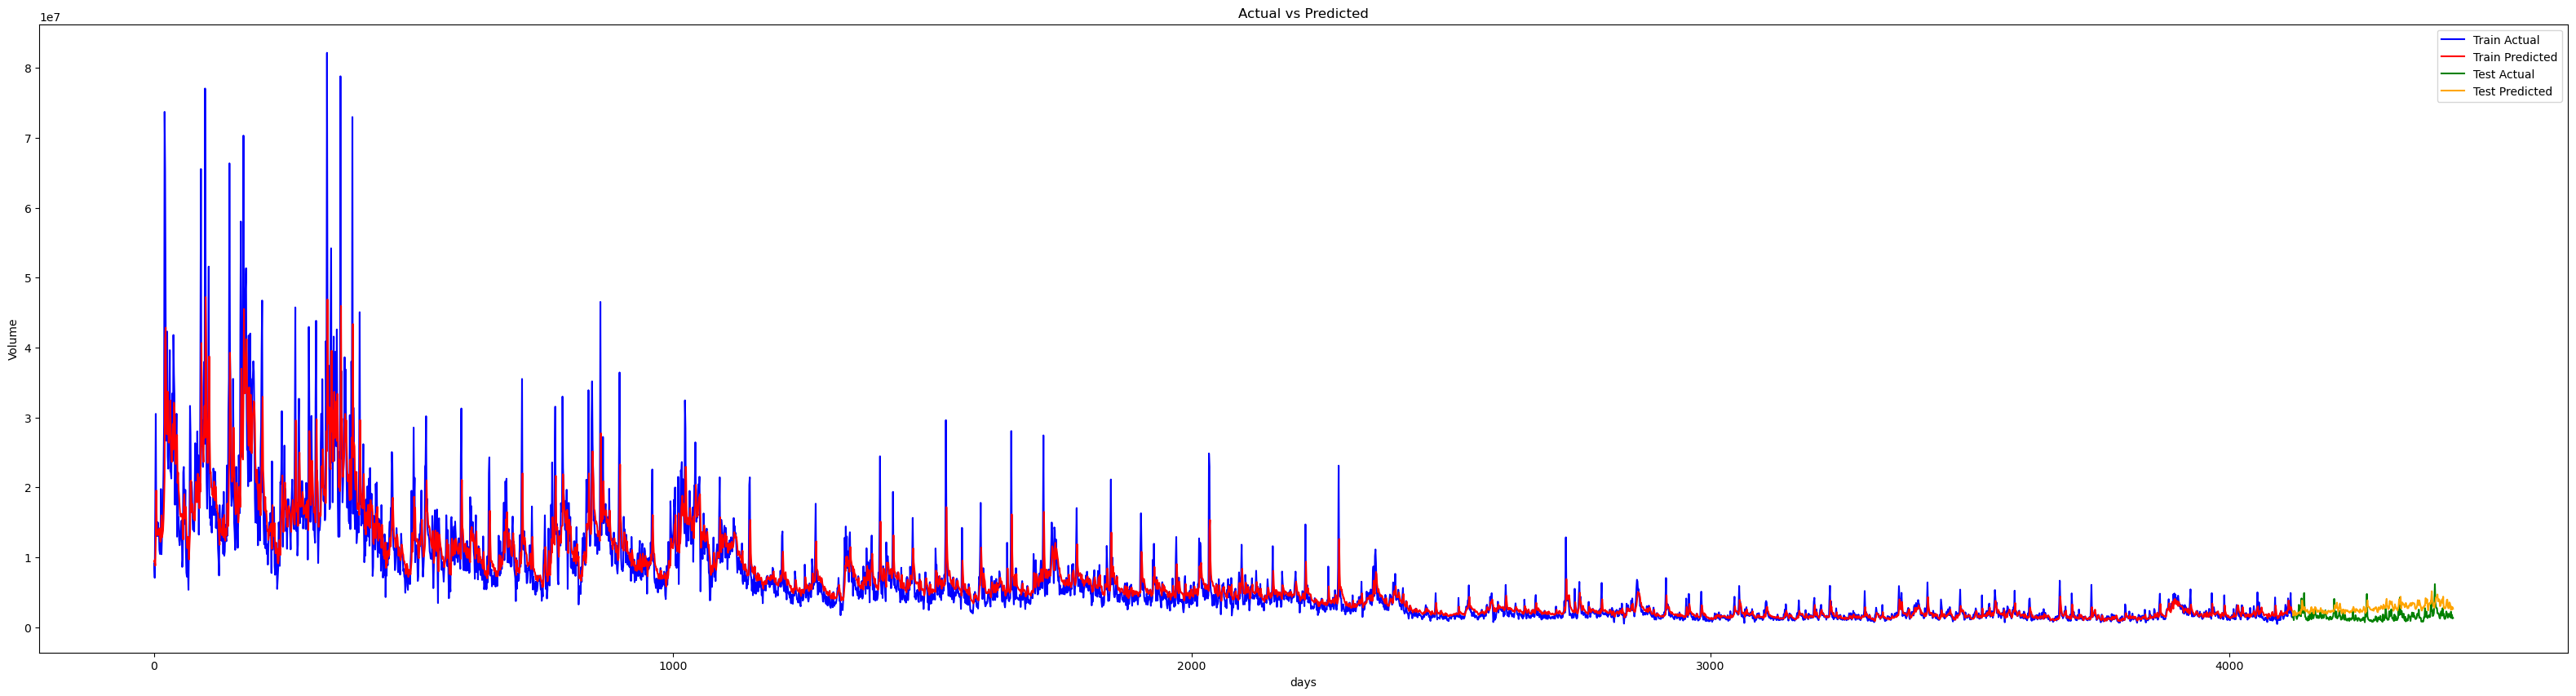

In [62]:
# Plotting for both the training and test set
plt.figure(figsize=(40,10))
plt.plot(np.arange(len(y_train)), y_train[:, 3], color='blue', label='Train Actual')
plt.plot(np.arange(len(y_train)), y_pred_train[:, 3], color='red', label='Train Predicted')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test[:, 3], color='green', label='Test Actual')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_test)), y_pred_test[:, 3], color='orange', label='Test Predicted')

plt.title('Actual vs Predicted')
plt.xlabel('days')
plt.ylabel('Volume')
plt.legend()
plt.show()

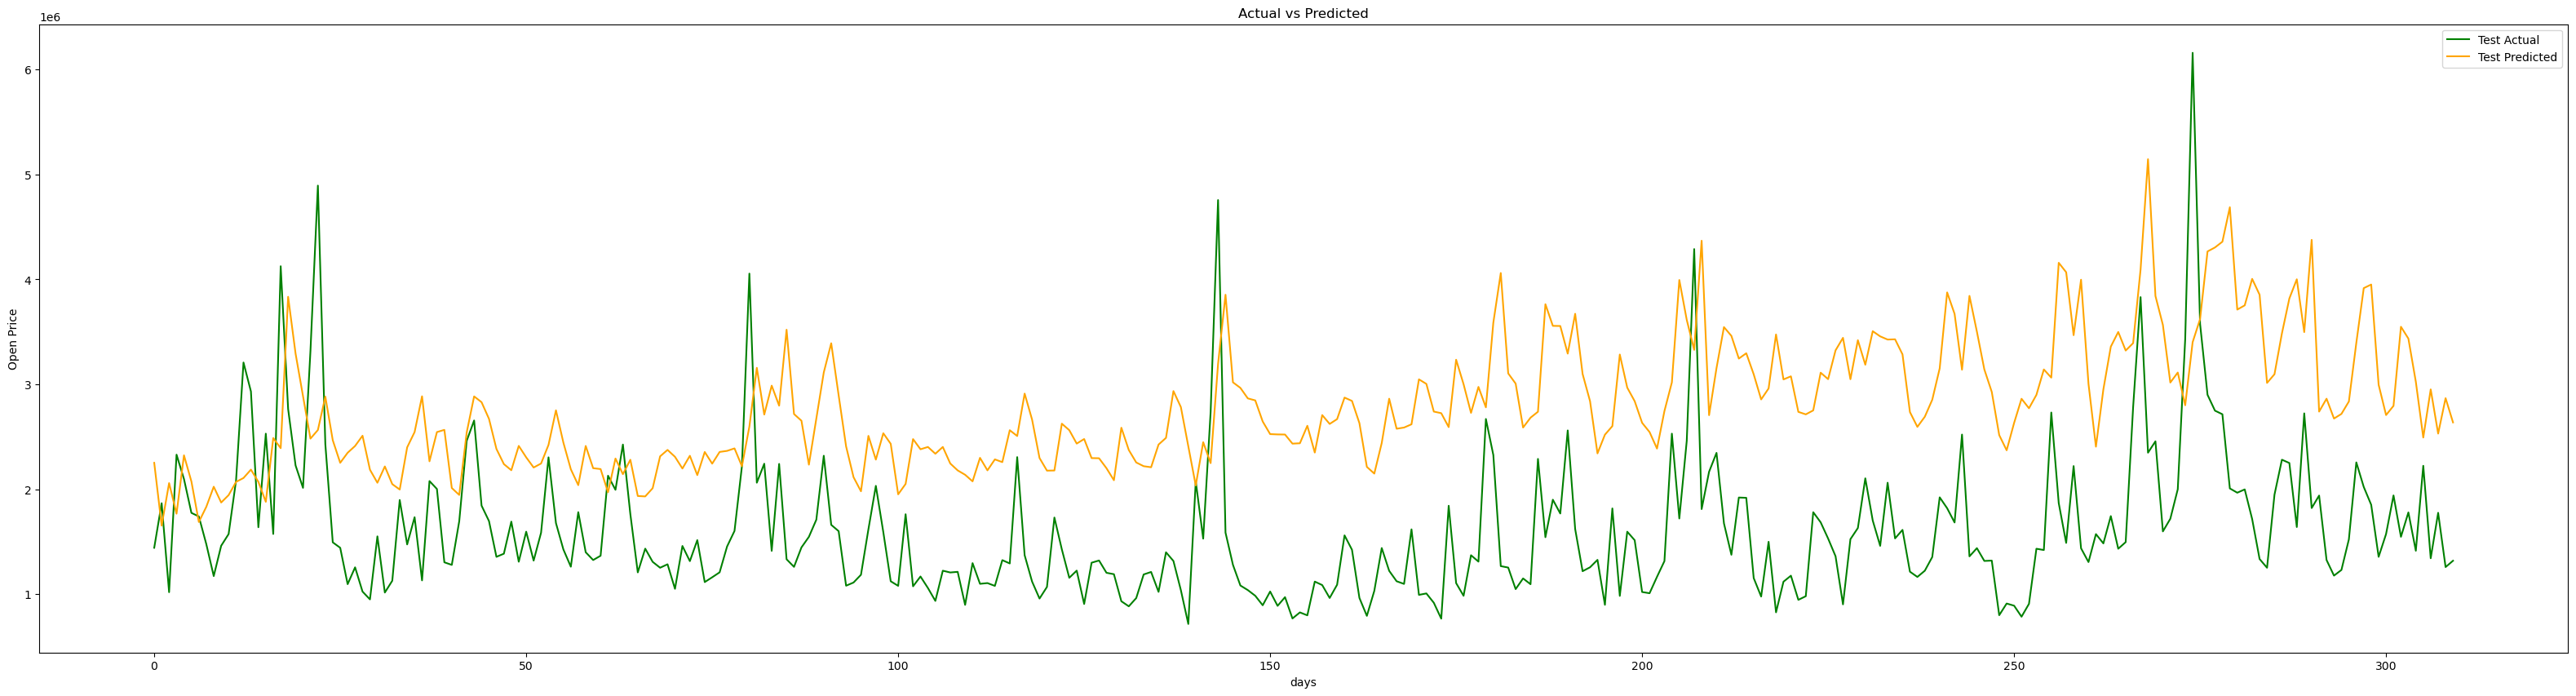

In [63]:
plt.figure(figsize=(40,10))
plt.plot(np.arange(len(y_test)), y_test[:, 3], color='green', label='Test Actual')
plt.plot(np.arange(len(y_pred_test)), y_pred_test[:, 3], color='orange', label='Test Predicted')

plt.title('Actual vs Predicted')
plt.xlabel('days')
plt.ylabel('Open Price')
plt.legend()
plt.show()